## Day 25 Lecture 1 Assignment

In this assignment, we will evaluate the performance of the model we built yesterday on the Chicago traffic crash data. We will also perform hyperparameter tuning and evaluate a final model using additional metrics (e.g. AUC-ROC, precision, recall, etc.)

In [34]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm


import numpy as np
import pandas as pd

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    log_loss,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    make_scorer,
)
from sklearn.calibration import calibration_curve

from sklearn.metrics import confusion_matrix, classification_report, log_loss

In [2]:
# answer goes here
def missingness_summary(df, print_log=False, sort='none'):
    summary = df.apply(lambda x: x.isna().sum() / x.shape[0])
    
    if print_log == True:
        if sort == 'none':
            print(summary)
        elif sort == 'ascending':
            print(summary.sort_values())
        elif sort == 'descending':
            print(summary.sort_values(ascending=False))
        else:
            print('Invalid value for sort parameter.')
        
    return summary

In [3]:
crash_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/traffic_crashes_chicago.csv')

In [4]:
crash_data['is_over_1500'] = crash_data['DAMAGE'] == 'OVER $1,500'
crash_data['is_over_1500'] = crash_data['is_over_1500'].astype(int)

crash_data = crash_data.drop(columns=['DAMAGE'])

In [5]:
is_na_perc = crash_data.isna().mean()
drop_cols = is_na_perc[is_na_perc > 0.05].index
crash_data = crash_data.drop(columns=drop_cols)

# Imputing the median for numeric columns with less than 5% missing data (except for STREET_NO)
col_medians = crash_data.drop(columns='STREET_NO').median()
crash_data = crash_data.fillna(col_medians)

# Dropping rows with missing data for categorical columns that have less than 5% missing data
crash_data = crash_data.dropna()




In [6]:
x_cols = ['POSTED_SPEED_LIMIT', 'WEATHER_CONDITION', 'INJURIES_TOTAL', 'FIRST_CRASH_TYPE']
X = crash_data[x_cols]
y = crash_data['is_over_1500']

drop_cats = ['WEATHER_CONDITION_CLEAR', 'FIRST_CRASH_TYPE_REAR END']
X_dummies = pd.get_dummies(X)
X_dummies = X_dummies.drop(columns=drop_cats)

X_train, X_test, y_train, y_test = train_test_split(
    X_dummies, y, test_size=0.2, random_state=42
)

Since we will be building on the model we built in the last assignment, we will need to redo all of the data preparation steps up to the point of model building. These steps include creating the response, missing value imputation, and one-hot encoding our selected categorical variables. The quickest way to get going would be to open last week's assignment, make a copy, and build on it from there.

Statsmodels' implementation of logistic has certain advantages over scikit-learn's, such as clean, easy to read model summary output and statistical inference values (e.g. p-values). However, scikit-learn is preferable for model evaluation, so we will switch to the scikit-learn implementation for this exercise. 

Run logistic regression on the training set and use the resulting model to make predictions on the test set. Calculate the train and test error using logarithmic loss. How do they compare to each other?

In [11]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
y_pred_test = model.predict(X_test)

In [16]:
y_pred_train = model.predict(X_train)

In [17]:
log_loss(y_train, y_pred_train)

14.398608851764356

In [15]:
# test error
log_loss(y_test, y_pred_test)

14.301795810256122

Next, evaluate the performance of the same model using 10-fold CV. Use the training data and labels, and print out the mean log loss for each of the 10 CV folds, as well as the overall CV-estimated test error. How do the estimates from the individual folds compare to the result from our previous single holdout set? How much variability in the estimated test error do you see across the 10 folds?

Note: scikit-learn's *cross_val_score* function provides a simple, one-line method for doing this. However, be careful - the default score returned by this function may not be log loss!

In [29]:
# answer goes here
cross_val_score(model, X_train, y_train, scoring=make_scorer(log_loss), cv=2)




array([14.43124222, 14.37359653])

In [32]:
cross_val_score(model, X_train, y_train, cv=2)


array([0.58217983, 0.58384888])

Scikit-learn's logistic regression function has a built-in regularization parameter, C (the larger the value of C, the smaller the degree of regularization). Use a loop with values of C, and find the optimum C value by taking the highest average cross validation score.

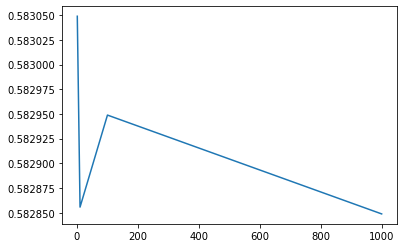

In [36]:
# answer goes here
cs = [1, 10, 100, 1000]

avg_cv_scores = []
for c in tqdm(cs):
    model = LogisticRegression(C=c, max_iter=1000)

    # pick your poison
    cv_scores = cross_val_score(model, X_train, y_train, cv=3)
    #     cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=log_loss_scorer)

    avg_cv_score = cv_scores.mean()
    avg_cv_scores.append(avg_cv_score)

plt.plot(cs, avg_cv_scores)
plt.show()

Re-train a logistic regression model using the best value of C identified by 10-fold CV on the training data and labels. Afterwards, do the following:

- Determine the precision, recall, and F1-score of our model using a cutoff/threshold of 0.5 (hint: scikit-learn's *classification_report* function may be helpful)
- Plot or otherwise generate a confusion matrix
- Plot the ROC curve for our logistic regression model

Note: the performance of our simple logistic regression model with just four features will not be very good, but this is not entirely unexpected. There are many other features that can be incorporated into the model to improve its performance; feel free to experiment!

In [39]:
# answer goes here
model = LogisticRegression(C=1, max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
y_prob_1 = y_prob[:, 1]